### A notebook with torch based code which can utilize CUDA, can be run on COLAB if data files are setup correctly

In [57]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import random



In [58]:
# Adjust file reading if we are on google colab

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    from google.colab import drive
    drive.mount('/content/drive')
    train_path = '/content/drive/MyDrive/DD2358_Data/train.csv'
    test_path = '/content/drive/MyDrive/DD2358_Data/test.csv'
else:
    train_path = '../data/train.csv'
    test_path = '../data/test.csv'


# Seeds
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda


### Import data

In [59]:
# Read files
train_df = pd.read_csv(train_path, header = None)
test_df = pd.read_csv(test_path, header = None)


# Check data sizes and class balances
print("Number of samples in train file: " + str(train_df.shape[0]))
print("Number of samples in test file: " + str(test_df.shape[0]))

# Check Class balance in train and test
print("\nNumber of class 0 in train file: " + str(train_df[0].eq(0).sum()) + f", {float(train_df[0].eq(0).sum()/train_df.shape[0]):.2f}% of train set")
print("Number of class 1 in train file: " + str(train_df[0].eq(1).sum()) + f", {float(train_df[0].eq(1).sum()/train_df.shape[0]):.2f}% of train set")
print("Number of class 2 in train file: " + str(train_df[0].eq(2).sum()) + f", {float(train_df[0].eq(2).sum()/train_df.shape[0]):.2f}% of train set")

print("\nNumber of class 0 in test file: " + str(test_df[0].eq(0).sum()) + f", {float(test_df[0].eq(0).sum()/test_df.shape[0]):.2f}% of test set")
print("Number of class 1 in test file: " + str(test_df[0].eq(1).sum()) + f", {float(test_df[0].eq(1).sum()/test_df.shape[0]):.2f}% of test set")
print("Number of class 0 in test file: " + str(test_df[0].eq(2).sum()) + f", {float(test_df[0].eq(2).sum()/test_df.shape[0]):.2f}% of test set")




Number of samples in train file: 2700
Number of samples in test file: 675

Number of class 0 in train file: 900, 0.33% of train set
Number of class 1 in train file: 900, 0.33% of train set
Number of class 2 in train file: 900, 0.33% of train set

Number of class 0 in test file: 225, 0.33% of test set
Number of class 1 in test file: 225, 0.33% of test set
Number of class 0 in test file: 225, 0.33% of test set


### Datasets are perfectly balanced, lets split it into X and Y and normalise the data

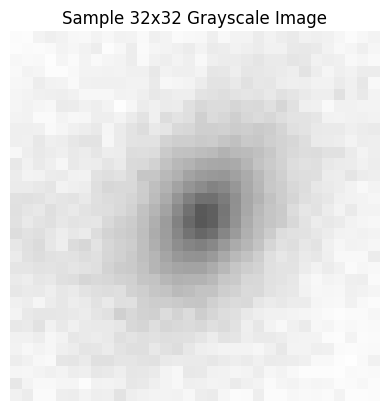

In [60]:
# Train data
train_X = train_df.iloc[:, 1:].values.astype(np.float32)
train_Y = train_df.iloc[:, 0].values

# Test data
test_X = test_df.iloc[:, 1:].values.astype(np.float32)
test_Y = test_df.iloc[:, 0].values

# Normalise the X values to [0,1]
train_X /= np.float32(255)
test_X /= np.float32(255)

# Convert to tensors
train_X = torch.tensor(train_X)
train_Y = torch.tensor(train_Y)
test_X = torch.tensor(test_X)
test_Y = torch.tensor(test_Y)

sample_image = train_X[200,:].reshape(32,32)
plt.imshow(sample_image, cmap='gray', vmin=0, vmax=1)
plt.title("Sample 32x32 Grayscale Image")
plt.axis('off')
plt.show()





### Model parameters and constructing dataloader

In [61]:
# Dataloader
batch_size = train_X.shape[0]
print(batch_size)

train_dataset = TensorDataset(train_X, train_Y)
test_dataset  = TensorDataset(test_X, test_Y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model parameters
input_dim = train_X.shape[1]  # 1024 pixels
hidden_dim1 = 8
#hidden_dim2 = 64
output_dim = 3  # 3 classes

2700


### Construct the Model with nn Module

In [ ]:
# Key note: ReLU was way better than Sigmoid by default in torch, this is because
# Weights initilization is Kaiming uniform, and not Xavi which is needed for Sigmoid

# Great model is lr = 0.001, decrease of factor 0.8 with patience = 10 on linear lr_scheduler

class MLP (nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1, bias=True),
            #nn.BatchNorm1d(hidden_dim1),
            nn.Sigmoid(),
            #nn.Dropout(0.1),
            nn.Linear(hidden_dim1, output_dim, bias=True),
        )

    def forward(self, x):
        return self.net(x)


# Use the same wegiths scaling as the baseline code, however we noticed RELU was supperior. Or if we decide to use Sigmoid, one should really do xavier scaling and not uniform
def init_weights(m):
    if isinstance(m, nn.Linear):
        # Initialize weights uniformly in the range [-0.2, 0.2]
        nn.init.uniform_(m.weight, -0.2, 0.2)
        # Optionally, initialize biases to zero
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# COMPILATION OPTIMIZATION
use_compile = False # Set to False to disable compilation with torch.compile()

model = MLP(input_dim, hidden_dim1, output_dim).to(device)
model.apply(init_weights)
if use_compile:
    model = torch.compile(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.8, patience=10, verbose=True)

MLP(
  (net): Sequential(
    (0): Linear(in_features=1024, out_features=8, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=8, out_features=3, bias=True)
  )
)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Lets train it

Epoch 1/600 | Train Loss: 1.0988 | Val Loss: 1.0988 | Val Acc: 29.93%
Epoch 2/600 | Train Loss: 1.0986 | Val Loss: 1.0978 | Val Acc: 32.15%
Epoch 3/600 | Train Loss: 1.0976 | Val Loss: 1.0971 | Val Acc: 39.41%
Epoch 4/600 | Train Loss: 1.0967 | Val Loss: 1.0966 | Val Acc: 37.63%
Epoch 5/600 | Train Loss: 1.0962 | Val Loss: 1.0962 | Val Acc: 39.26%
Epoch 6/600 | Train Loss: 1.0959 | Val Loss: 1.0960 | Val Acc: 34.96%
Epoch 7/600 | Train Loss: 1.0957 | Val Loss: 1.0957 | Val Acc: 38.52%
Epoch 8/600 | Train Loss: 1.0953 | Val Loss: 1.0955 | Val Acc: 41.78%
Epoch 9/600 | Train Loss: 1.0950 | Val Loss: 1.0953 | Val Acc: 39.85%
Epoch 10/600 | Train Loss: 1.0947 | Val Loss: 1.0951 | Val Acc: 39.56%
Epoch 11/600 | Train Loss: 1.0945 | Val Loss: 1.0947 | Val Acc: 37.48%
Epoch 12/600 | Train Loss: 1.0942 | Val Loss: 1.0945 | Val Acc: 38.37%
Epoch 13/600 | Train Loss: 1.0939 | Val Loss: 1.0943 | Val Acc: 38.96%
Epoch 14/600 | Train Loss: 1.0938 | Val Loss: 1.0941 | Val Acc: 37.63%
Epoch 15/600 | 

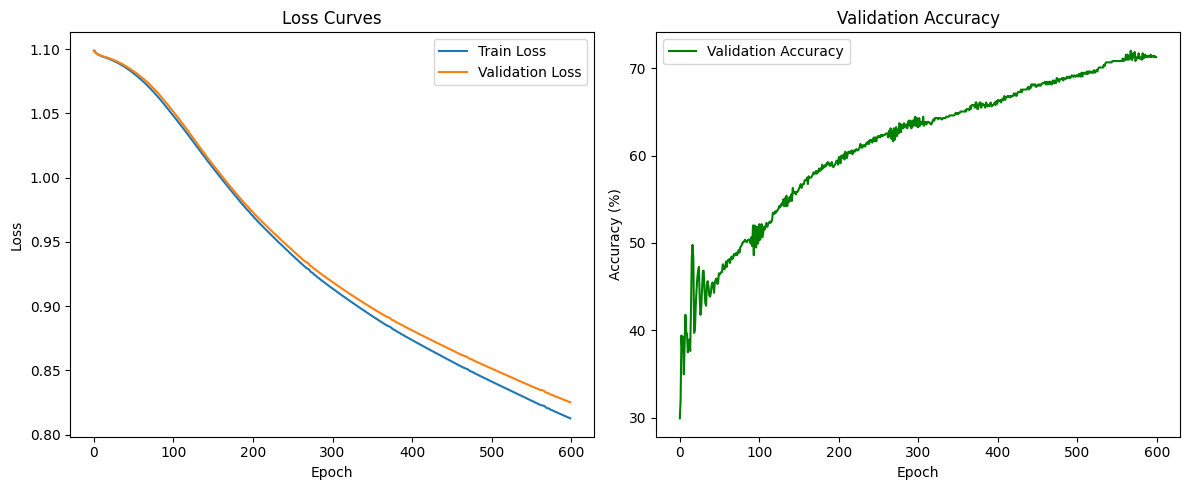

Final Test Accuracy: 71.26%
tensor([ 0.1013, -0.0468,  0.0371,  ...,  0.0227,  0.2164,  0.0915],
       device='cuda:0', grad_fn=<SelectBackward0>)


In [ ]:
num_epochs = 600
patience = 100  # if no improvement for x epochs, stop training
best_val_loss = float('inf')
epochs_without_improve = 0
train_losses = []
val_losses = []
val_accuracies = []
best_model_state = None

import time
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)  # raw logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_dataset)
    train_losses.append(train_loss)

    # Evaluate on validation (test) set
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_loss = running_val_loss / len(test_dataset)
    val_acc = 100.0 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        epochs_without_improve = 0
    else:
        epochs_without_improve += 1
        if epochs_without_improve >= patience:
            print("Early stopping triggered.")
            break



# Plot Training and Validation Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


# Final Evaluation on Test Set
if best_model_state is not None:
    model.load_state_dict(best_model_state)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
final_acc = 100.0 * correct / total
print("Final Test Accuracy: {:.2f}%".format(final_acc))

# End timer and print execution time
elapsed_time = time.time() - start_time
print(f"Total Execution Time: {elapsed_time:.2f} seconds")

### General Notes from testing:

Double hidden layer with more neurons in first than second improvs the models accuracy potential. Using Relu, dropout(0.3) and layersizes = [input_dim, 128, 64, output_dim] worked well with this. Good generelization. Really seems to be aproblem in need of two hidden layers

However, Dropout is only relevant if we have large enough network, otherwise the model becomes way too simple and cant learn properly

For Double layer architecure the nn.BatchNordm1d(any_hidden_layer_dim) after the nn.linear and before activation function is absolutely fundamental. Without - > 46% final accuracy, with it for both the linear from input to hidden1 and from hidden1 to hidden2 we get 86% accuracy. Absolutely fundamental.

Significant improvement for this dataset with ReLu in comparisson to Sigmoid, 70 -> 86% validation accuracy

Suspect that the training and test data have bad seed and overall arent a good split, as training probably dont represent test good enough

Lower learning rate = More stable improvement, but does converge earlier with a little worse accuracy



TODO:

To pass assignment:
- Fix the loss and optimizer to somehow incorporate the customized loss and optimizer in the original code. The problem is getting that to run with torch

For fun:
- Understand BatchNorm1d
- Dropout effect on different layer sizes
- Should the layer sizes in a MLP only decrease layer by layer (Not risk the problem of simply copying from layer to another, there was fix for this problem though somehow (See sparse autoencdoers))